<a href="https://colab.research.google.com/github/alexandrebatista/cifar10-classifier/blob/master/cifar_wnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/alexandrebatista/cifar10-classifier.git

Cloning into 'cifar10-classifier'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 31 (delta 10), reused 20 (delta 2), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [2]:
!pip install wisardpkg

     |████████████████████████████████| 133kB 5.7MB/s 
     |████████████████████████████████| 194kB 25.1MB/s 
  ERROR: Failed building wheel for wisardpkg
  Running setup.py clean for wisardpkg
Failed to build wisardpkg
    Running setup.py install for wisardpkg ... done


In [3]:
!python /content/cifar10-classifier/mnist_classifier.py

Acc: 0.9228571428571428


## Pré-Processamento

Pensei em testar alguns métodos de pré-processamento. A idéia é aumentar o banco de treino para tentar aumentar a robustez do modelo:

* shifting: rotacionar, transladar e alterar o zoom das imagens (para nós, pode parecer a mesma imagem, mas para a máquina são imagens diferentes).

* filtros: aplicar alguns filtros para realçar determinadas features.

Referências:

https://towardsdatascience.com/how-to-improve-your-image-classifier-with-googles-autoaugment-77643f0be0c9

https://github.com/DeepVoltaire/AutoAugment

https://towardsdatascience.com/image-filters-in-python-26ee938e57d2


In [6]:
!git clone https://github.com/DeepVoltaire/AutoAugment.git

Cloning into 'AutoAugment'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 140 (delta 0), reused 1 (delta 0), pack-reused 136
Receiving objects: 100% (140/140), 35.59 MiB | 30.55 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [9]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pdb
from autoaugment import ImageNetPolicy, CIFAR10Policy, SVHNPolicy, SubPolicy

In [10]:
import PIL
print("Using Pillow version {}. Upgrade using 'pip install Pillow -U'".format(PIL.__version__))

Using Pillow version 7.0.0. Upgrade using 'pip install Pillow -U'


170500096/170498071 [==============================] - 2s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


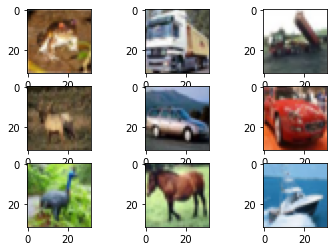

In [12]:
# example of loading the cifar10 dataset
from matplotlib import pyplot
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i])
# show the figure
pyplot.show()

In [11]:
def show_sixteen(images, titles=0):
    f, axarr = plt.subplots(4, 4, figsize=(15, 15), gridspec_kw={"wspace": 0, "hspace": 0})
    for idx, ax in enumerate(f.axes):
        ax.imshow(images[idx])
        ax.axis("off")
        if titles: ax.set_title(titles[idx])
    plt.show()

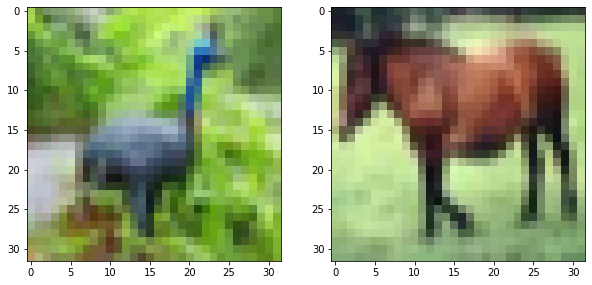

In [23]:
img = trainX[6]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1.imshow(img)
img2 = trainX[7]
ax2.imshow(img2)
plt.show()

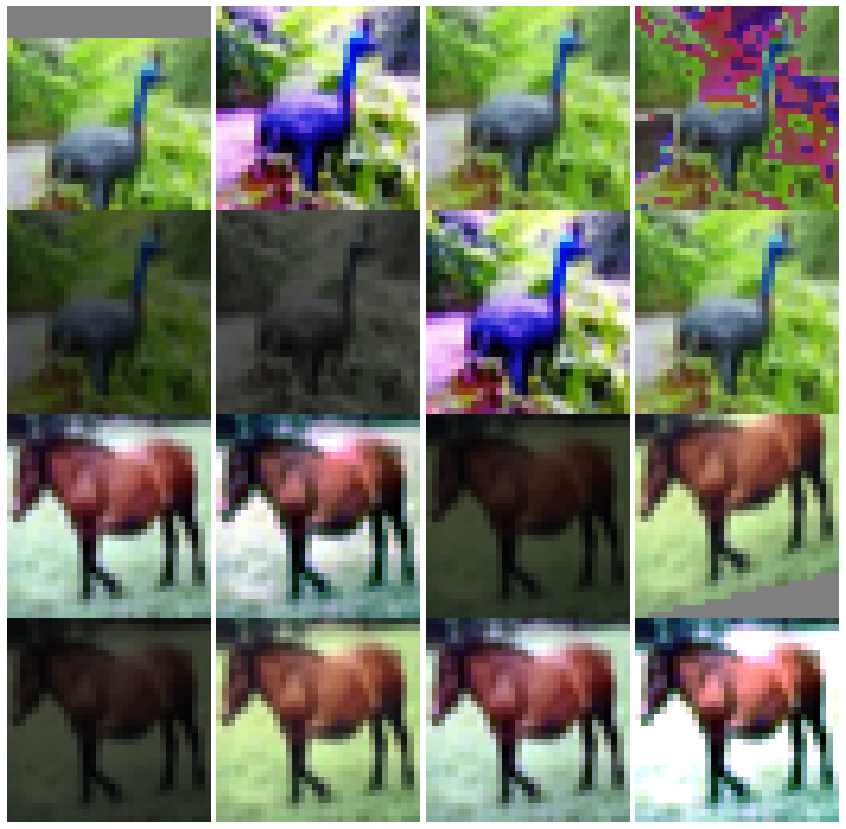

In [28]:
img1a = PIL.Image.fromarray(img)
img2a = PIL.Image.fromarray(img2)

#policy = ImageNetPolicy()
policy = CIFAR10Policy()

imgs = []
for _ in range(8): imgs.append(policy(img1a))
for _ in range(8): imgs.append(policy(img2a))
show_sixteen(imgs)

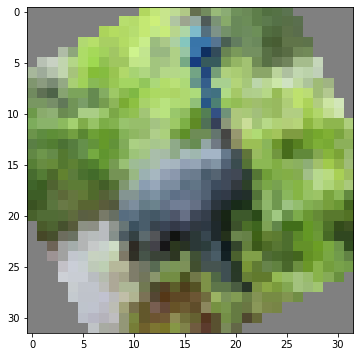

In [26]:
teste = np.asarray(imgs[0]) 
f, ax1 = plt.subplots(1, 1, figsize=(10,6))
ax1.imshow(teste)

In [ ]:
%%time
def preproc(trainX, trainy, nsample=8):
  ntrainX = []
  ntrainy = []

  for tX, ty in zip(trainX, trainy):
    tXimg = PIL.Image.fromarray(tX)
    policy = CIFAR10Policy()
    for _ in range(nsample): ntrainX.append(np.asarray(policy(tXimg)))
    for _ in range(nsample): ntrainy.append(ty)

  return np.array(ntrainX), np.array(ntrainy)


ntrainX, ntrainy = preproc(trainX, trainy, nsample=3)
print('Train: X=%s, y=%s' % (ntrainX.shape, ntrainy.shape))

In [36]:
import wisardpkg as wp
def simple_cifar(train_data, train_labels, test_data, test_labels):

  def flatten(char):
      return np.reshape(char, (-1,)).tolist()

  # ----------------------------------------------------------------------------------------------------------------------
  # Preprocessing data

  # Converting labels from int to string
  train_labels = [str(label) for label in train_labels]
  test_labels = [str(label) for label in test_labels]

  threshold = 125
  X = np.where(train_data > threshold, 1, 0)
  y = np.where(test_data > threshold, 1, 0)
  # trainingSet, validationSet, testSet = np.split(X, [int(len(X) * 0.8), int(len(X) * 0.9)])
  # trainingSetY, validationSetY, testSetY = np.split(y, [int(len(y) * 0.8), int(len(y) * 0.9)])

  X = [flatten(sample) for sample in X]
  y = [flatten(sample) for sample in y]

  # ----------------------------------------------------------------------------------------------------------------------
  # Setting model

  addressSize = 28
  ignoreZero = False

  model = wp.Wisard(addressSize, ignoreZero=ignoreZero, verbose=True)

  # ----------------------------------------------------------------------------------------------------------------------
  # Training
  model.train(X, train_labels)

  # ----------------------------------------------------------------------------------------------------------------------
  # Testing
  out = model.classify(y)

  # ----------------------------------------------------------------------------------------------------------------------
  # Evaluation
  hits = 0
  for index in range(0, len(out)):
      if str(out[index]) == str(test_labels[index]):
          hits = hits + 1

  acc = float(hits) / len(test_labels)
  print('Acc: ' + str(acc))
  return

CPU times: user 0 ns, sys: 15 µs, total: 15 µs
Wall time: 17.9 µs


In [37]:
%%time
# original
simple_cifar(trainX, trainy, testX, testy)

Acc: 0.3189
CPU times: user 22.3 s, sys: 1.38 s, total: 23.7 s
Wall time: 23.7 s


In [38]:
%%time
# x2
simple_cifar(ntrainX, ntrainy, testX, testy)

Acc: 0.3018
CPU times: user 34.4 s, sys: 4.54 s, total: 39 s
Wall time: 39 s


In [ ]:
%%time
# x3
simple_cifar(ntrainX, ntrainy, testX, testy)